In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
#dataset2
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hackathon/Datasets2_join.csv', index_col='timeStamp',parse_dates=True)
df.drop('Time',axis=1,inplace=True)

In [99]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8641 entries, 2018-12-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   availableMW       8638 non-null   float64
 1   windSpeed         8634 non-null   float64
 2   windPower         8634 non-null   float64
 3   windSpeed (m/s)   721 non-null    float64
 4   windDic (degree)  721 non-null    float64
dtypes: float64(5)
memory usage: 405.0 KB


availableMW            3
windSpeed              7
windPower              7
windSpeed (m/s)     7920
windDic (degree)    7920
dtype: int64

#Limpiar datos

calmas y windspeed <=3.5 m/s

availableMW <90

In [100]:
df.head(2)

,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree)
timeStamp,,,,,
2018-12-01 00:00:00,77.4,4.5,3.00625,2.77218,348.166
2018-12-01 00:05:00,77.4,4.8,5.65763,NaN,NaN


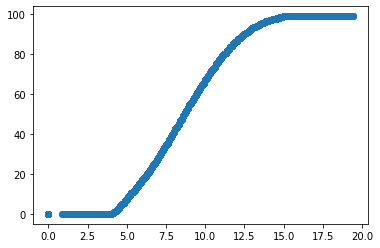

In [101]:
plt.scatter(df['windSpeed'],df['windPower'])

In [102]:
df.windPower[df['windSpeed']<=3.5]= np.NaN
df.windSpeed[df['windSpeed']<=3.5]= np.NaN
df.availableMW[df['windSpeed']<=3.5]= np.NaN

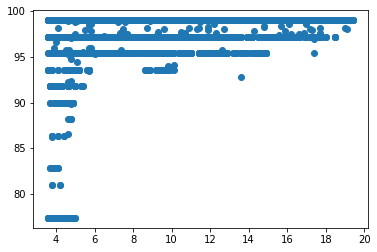

In [103]:
plt.scatter(df['windSpeed'],df['availableMW'])

In [104]:
df.availableMW[df.availableMW<90]= np.NaN

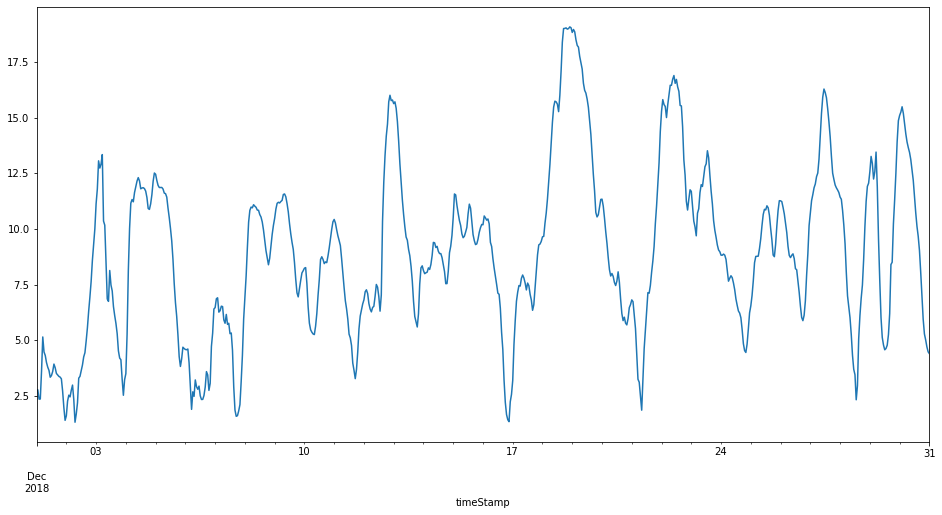

In [105]:
df['windSpeed (m/s)'][~df['windSpeed (m/s)'].isnull()].plot(figsize=(16,8))

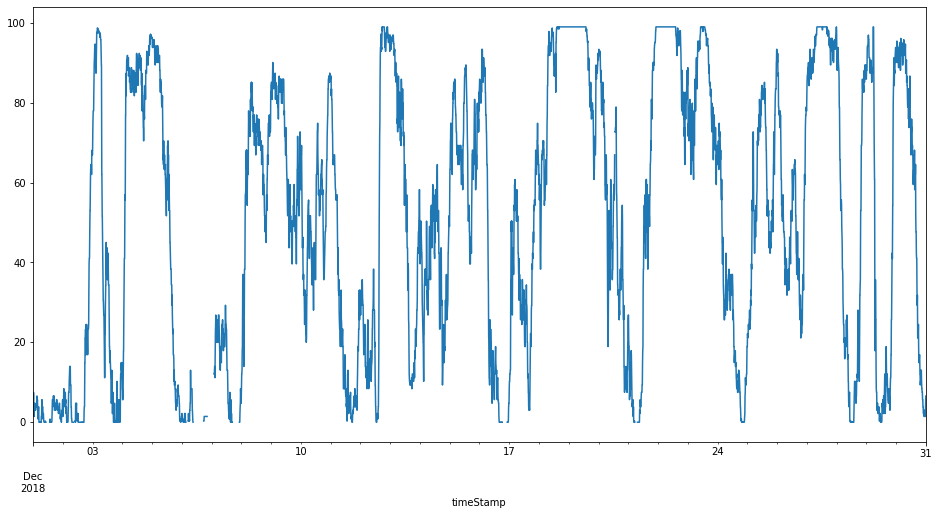

In [106]:
df['windPower'].plot(figsize=(16,8))

In [107]:
print(df.isnull().sum())
print(df.describe())
print(df.info())

availableMW          257
windSpeed            492
windPower            492
windSpeed (m/s)     7920
windDic (degree)    7920
dtype: int64
       availableMW    windSpeed    windPower  windSpeed (m/s)  windDic (degree)
count  8384.000000  8149.000000  8149.000000       721.000000        721.000000
mean     98.148330     9.339931    52.988980         8.903373        263.305245
std       1.536902     3.621793    33.928128         3.871640         66.645270
min      90.000000     3.600000     0.000000         1.308578         13.547907
25%      97.200000     6.300000    20.009000         6.190473        244.317625
50%      99.000000     9.200000    56.944500         8.802624        289.725625
75%      99.000000    11.800000    85.128700        11.270112        309.843875
max      99.000000    19.400000    99.000000        19.083787        353.798375
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8641 entries, 2018-12-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 5 columns):


#Ajuste lineal para rellenar cada 5 min el forecast

Text(0.5, 0, 'wind speed (forecast hourly)')

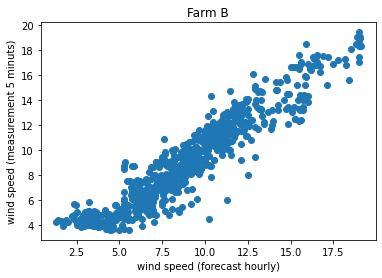

In [108]:
#relacion lineal
plt.scatter(df['windSpeed (m/s)'],df.windSpeed)
plt.title("Farm B")
plt.ylabel("wind speed (measurement 5 minuts)")
plt.xlabel("wind speed (forecast hourly)")

In [109]:
#time variables
df['year']=df.index.year
df['month']=df.index.month
df['day']=df.index.dayofyear
df['hour']=df.index.hour
df['minute']=df.index.minute
df.head(5)


,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree),year,month,day,hour,minute
timeStamp,,,,,,,,,,
2018-12-01 00:00:00,NaN,4.5,3.00625,2.77218,348.166,2018,12,335,0,0
2018-12-01 00:05:00,NaN,4.8,5.65763,NaN,NaN,2018,12,335,0,5
2018-12-01 00:10:00,NaN,4.8,5.65763,NaN,NaN,2018,12,335,0,10
2018-12-01 00:15:00,NaN,5.0,7.48540,NaN,NaN,2018,12,335,0,15
2018-12-01 00:20:00,NaN,5.0,7.48540,NaN,NaN,2018,12,335,0,20


In [110]:
#lineal adjust
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
df['WSF_int']=df['windSpeed (m/s)'].interpolate()

In [112]:
#quitar nulos de wind speed
df_ws=df[df['windSpeed'].notna()]
df_ws.reset_index(inplace=True)
df_ws.head(5)

,timeStamp,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree),year,month,day,hour,minute,WSF_int
0,2018-12-01 00:00:00,NaN,4.5,3.00625,2.77218,348.166,2018,12,335,0,0,2.772180
1,2018-12-01 00:05:00,NaN,4.8,5.65763,NaN,NaN,2018,12,335,0,5,2.771358
2,2018-12-01 00:10:00,NaN,4.8,5.65763,NaN,NaN,2018,12,335,0,10,2.770537
3,2018-12-01 00:15:00,NaN,5.0,7.48540,NaN,NaN,2018,12,335,0,15,2.769715
4,2018-12-01 00:20:00,NaN,5.0,7.48540,NaN,NaN,2018,12,335,0,20,2.768893


In [113]:
#df_ws.head(5)
df_ws.isnull().sum()

timeStamp              0
availableMW          144
windSpeed              0
windPower              0
windSpeed (m/s)     7468
windDic (degree)    7468
year                   0
month                  0
day                    0
hour                   0
minute                 0
WSF_int                0
dtype: int64

In [114]:
#standarize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_array=np.array(df_ws[['year','month','day','hour','minute','WSF_int']].values)

scaler.fit(df_array)
df_est=scaler.transform(df_array)
print(df_est)

[[ 0.          0.         -1.73622533 -1.63607713 -1.58983166 -1.75061562]
 [ 0.          0.         -1.73622533 -1.63607713 -1.3003483  -1.75083784]
 [ 0.          0.         -1.73622533 -1.63607713 -1.01086495 -1.75106006]
 ...
 [ 0.          0.          1.64342548  1.67563883  1.30500192 -1.30890436]
 [ 0.          0.          1.64342548  1.67563883  1.59448528 -1.3107732 ]
 [ 0.          0.          1.75996516 -1.63607713 -1.58983166 -1.31264203]]


In [115]:
#define X y y
X = df_est
y = df_ws['windSpeed']

In [116]:
print(df_est.shape)
print(X.shape)
print(len(y))

(8149, 6)
(8149, 6)
8149


In [117]:
#train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [118]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [119]:
print(len(y_test))
print(len(y_pred))
X_test.shape


1630
1630


(1630, 6)

In [120]:
# The coefficients of linear reggresion
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


Intercept: 
 9.348729833932298
Coefficients: 
 [ 0.00000000e+00  4.44089210e-16 -1.43924112e-01 -5.82037114e-02
  1.96422612e-03  3.45197222e+00]
Mean squared error: 1.54
Coefficient of determination: 0.88


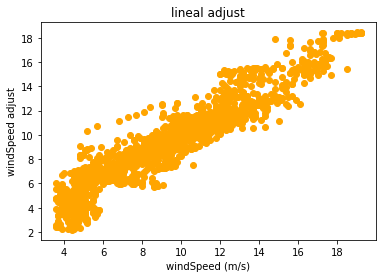

In [121]:
# Plot outputs
plt.scatter(y_test, y_pred,  color='orange')
#plt.plot(y, y_pred, color='blue', linewidth=3)
plt.xlabel('windSpeed (m/s)')
plt.ylabel('windSpeed adjust')
plt.title('lineal adjust')
plt.show()


In [122]:
df.index

DatetimeIndex(['2018-12-01 00:00:00', '2018-12-01 00:05:00',
               '2018-12-01 00:10:00', '2018-12-01 00:15:00',
               '2018-12-01 00:20:00', '2018-12-01 00:25:00',
               '2018-12-01 00:30:00', '2018-12-01 00:35:00',
               '2018-12-01 00:40:00', '2018-12-01 00:45:00',
               ...
               '2018-12-30 23:15:00', '2018-12-30 23:20:00',
               '2018-12-30 23:25:00', '2018-12-30 23:30:00',
               '2018-12-30 23:35:00', '2018-12-30 23:40:00',
               '2018-12-30 23:45:00', '2018-12-30 23:50:00',
               '2018-12-30 23:55:00', '2018-12-31 00:00:00'],
              dtype='datetime64[ns]', name='timeStamp', length=8641, freq=None)

In [123]:
#Genera serie de fechas completas para 2018
days=pd.date_range(start='2018-12-1', end='2019-1-1', freq='5min')
dates=pd.DataFrame(days,columns=['timeStamp'])
dates.set_index(pd.DatetimeIndex(dates['timeStamp']))
dates['year']=dates['timeStamp'].dt.year
dates['month']=dates['timeStamp'].dt.month
dates['day']=dates['timeStamp'].dt.dayofyear
dates['hour']=dates['timeStamp'].dt.hour
dates['minute']=dates['timeStamp'].dt.minute
dates=dates.iloc[0:-1,:]
dates

,timeStamp,year,month,day,hour,minute
0,2018-12-01 00:00:00,2018,12,335,0,0
1,2018-12-01 00:05:00,2018,12,335,0,5
2,2018-12-01 00:10:00,2018,12,335,0,10
3,2018-12-01 00:15:00,2018,12,335,0,15
4,2018-12-01 00:20:00,2018,12,335,0,20
...,...,...,...,...,...,...
8923,2018-12-31 23:35:00,2018,12,365,23,35
8924,2018-12-31 23:40:00,2018,12,365,23,40
8925,2018-12-31 23:45:00,2018,12,365,23,45
8926,2018-12-31 23:50:00,2018,12,365,23,50


In [124]:
#joint datasets in a dataset full
df_ws=df_ws.set_index('timeStamp').join(dates.set_index('timeStamp'),lsuffix='_m', rsuffix='_f', how='outer')
df_ws

,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree),year_m,month_m,day_m,hour_m,minute_m,WSF_int,year_f,month_f,day_f,hour_f,minute_f
timeStamp,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,NaN,4.5,3.00625,2.77218,348.166,2018.0,12.0,335.0,0.0,0.0,2.772180,2018,12,335,0,0
2018-12-01 00:05:00,NaN,4.8,5.65763,NaN,NaN,2018.0,12.0,335.0,0.0,5.0,2.771358,2018,12,335,0,5
2018-12-01 00:10:00,NaN,4.8,5.65763,NaN,NaN,2018.0,12.0,335.0,0.0,10.0,2.770537,2018,12,335,0,10
2018-12-01 00:15:00,NaN,5.0,7.48540,NaN,NaN,2018.0,12.0,335.0,0.0,15.0,2.769715,2018,12,335,0,15
2018-12-01 00:20:00,NaN,5.0,7.48540,NaN,NaN,2018.0,12.0,335.0,0.0,20.0,2.768893,2018,12,335,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,12,365,23,35
2018-12-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,12,365,23,40
2018-12-31 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,12,365,23,45


In [125]:
#Wind Speed 5 minutes adjust
#estandarizar base dull
scaler = StandardScaler()

df_array=np.array(df_ws[['year_f','month_f','day_f','hour_f','minute_f','WSF_int']].values)
scaler.fit(df_array)
df_est_f=scaler.transform(df_array)

ypred_5min=regr.intercept_+np.nansum((df_est_f*regr.coef_.T), axis=1)
#ypred_5min=regr.intercept_+(X*regr.coef_.T).sum(axis=1)
ypred_5min

array([3.64058717, 3.64038908, 3.64019098, ..., 9.012658  , 9.013227  ,
       9.01379601])

In [126]:
#Dataframe 5min forecast full
df_pred=pd.DataFrame(ypred_5min,columns=['windSpeed_5min'])
df_pred.set_index(df_ws.index)
df_pred['timeStamp']=df_ws.index
df_pred

,windSpeed_5min,timeStamp
0,3.640587,2018-12-01 00:00:00
1,3.640389,2018-12-01 00:05:00
2,3.640191,2018-12-01 00:10:00
3,3.639993,2018-12-01 00:15:00
4,3.639795,2018-12-01 00:20:00
...,...,...
8923,9.011520,2018-12-31 23:35:00
8924,9.012089,2018-12-31 23:40:00
8925,9.012658,2018-12-31 23:45:00
8926,9.013227,2018-12-31 23:50:00


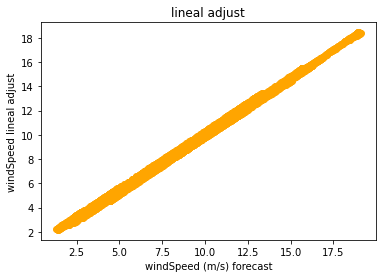

In [127]:
# Plot outputs interpolate vs regression lineal
plt.scatter(df_ws['WSF_int'], ypred_5min,  color='orange')
plt.xlabel('windSpeed (m/s) forecast')
plt.ylabel('windSpeed lineal adjust')
plt.title('lineal adjust')
plt.show()

In [128]:
# Create ridge regression object
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

y_ridge_pred = ridge.predict(X)
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [129]:
# The coefficients of linear reggresion
print('Intercept: \n', ridge.intercept_)
print('Coefficients: \n', ridge.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_ridge_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_ridge_pred))


Intercept: 
 9.339931279911646
Coefficients: 
 [ 0.00000000e+00  0.00000000e+00 -1.61761557e-01 -5.66494561e-02
  5.11549834e-04  3.45311960e+00]
Mean squared error: 1.47
Coefficient of determination: 0.89


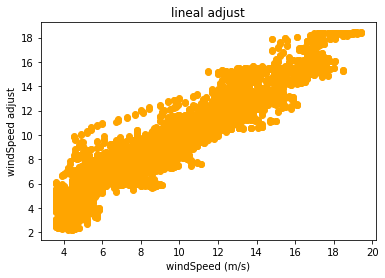

In [130]:
# Plot outputs
plt.scatter(y, y_ridge_pred,  color='orange')
plt.xlabel('windSpeed (m/s)')
plt.ylabel('windSpeed adjust')
plt.title('lineal adjust')
plt.show()

ValueError: ignored

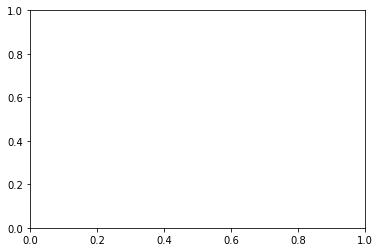

In [131]:
# Plot outputs interpolate vs regression lineal
plt.scatter(df_ws['WSF_int'], y_ridge_pred,  color='orange')
plt.xlabel('windSpeed interpolate')
plt.ylabel('windSpeed ridge')
plt.title('lineal adjust')
plt.show()

In [132]:
print(df_ws.head(2))
df_pred.head(2)

                     availableMW  windSpeed  windPower  ...  day_f  hour_f  minute_f
timeStamp                                               ...                         
2018-12-01 00:00:00          NaN        4.5    3.00625  ...    335       0         0
2018-12-01 00:05:00          NaN        4.8    5.65763  ...    335       0         5

[2 rows x 16 columns]


,windSpeed_5min,timeStamp
0,3.640587,2018-12-01 00:00:00
1,3.640389,2018-12-01 00:05:00


#Base con ajuste

In [133]:
df_adj=df_ws[['year_f','month_f','day_f','hour_f','minute_f','availableMW','windSpeed','windPower','windDic (degree)','WSF_int']]
df_adj.reset_index(inplace=True)

df_adj=df_adj.set_index('timeStamp').join(df_pred.set_index('timeStamp'),how='outer')
df_adj.columns=['year','month','day','hour','minute','availableMW','windSpeed','windPower','windDic (degree)','WSF_int','windSpeed_5min']
df_adj


,year,month,day,hour,minute,availableMW,windSpeed,windPower,windDic (degree),WSF_int,windSpeed_5min
timeStamp,,,,,,,,,,,
2018-12-01 00:00:00,2018,12,335,0,0,NaN,4.5,3.00625,348.166,2.772180,3.640587
2018-12-01 00:05:00,2018,12,335,0,5,NaN,4.8,5.65763,NaN,2.771358,3.640389
2018-12-01 00:10:00,2018,12,335,0,10,NaN,4.8,5.65763,NaN,2.770537,3.640191
2018-12-01 00:15:00,2018,12,335,0,15,NaN,5.0,7.48540,NaN,2.769715,3.639993
2018-12-01 00:20:00,2018,12,335,0,20,NaN,5.0,7.48540,NaN,2.768893,3.639795
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,2018,12,365,23,35,NaN,NaN,NaN,NaN,NaN,9.011520
2018-12-31 23:40:00,2018,12,365,23,40,NaN,NaN,NaN,NaN,NaN,9.012089
2018-12-31 23:45:00,2018,12,365,23,45,NaN,NaN,NaN,NaN,NaN,9.012658


In [ ]:
df_adj.to_csv('/content/drive/MyDrive/Colab Notebooks/Hackathon/Dataset2_full.csv')

In [ ]:
#Genera serie de fechas completas para 2018
days=pd.date_range(start='2018-12-1', end='2019-1-1', freq='5min')
dates=pd.DataFrame(days,columns=['timeStamp'])
dates.set_index(pd.DatetimeIndex(dates['timeStamp']))
dates['year']=dates['timeStamp'].dt.year
dates['month']=dates['timeStamp'].dt.month
dates['day']=dates['timeStamp'].dt.dayofyear
dates['hour']=dates['timeStamp'].dt.hour
dates['minute']=dates['timeStamp'].dt.minute
dates=dates.iloc[0:-1,:]
dates

#Carga Dataset3_forecast

In [176]:
#dataset3
#hay errores en las fechas
dforc=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hackathon/Dataset3_forecast_2.csv', index_col='timeStamp',parse_dates=True)
dforc


,Time,windSpeed (m/s),windDic (degree)
timeStamp,,,
2109-01-01 00:00:00,01/01/2019 00:00,3.55335,211.752
2019-01-01 01:00:00,01/01/2019 01:00,3.66734,195.937
2019-01-01 02:00:00,01/01/2019 02:00,3.96667,177.362
2019-01-01 03:00:00,01/01/2019 03:00,5.15375,155.847
2019-01-01 04:00:00,01/01/2019 04:00,7.60921,152.430
...,...,...,...
2019-03-29 06:00:00,01/12/2019 20:00,6.44321,306.024
2019-03-29 07:00:00,01/12/2019 21:00,6.50728,312.580
2019-03-29 08:00:00,01/12/2019 22:00,6.53122,306.911


In [180]:
#Genera serie de fechas completas para 2018
days=pd.date_range(start='2019-1-1', end='2019-4-1', freq='5min')
dates=pd.DataFrame(days,columns=['timeStamp'])
dates.set_index(pd.DatetimeIndex(dates['timeStamp']))
dates['year']=dates['timeStamp'].dt.year
dates['month']=dates['timeStamp'].dt.month
dates['day']=dates['timeStamp'].dt.dayofyear
dates['hour']=dates['timeStamp'].dt.hour
dates['minute']=dates['timeStamp'].dt.minute
dates=dates.iloc[0:-1,:]


#Genera serie de fechas completas para 2018
days=pd.date_range(start='2019-1-1', end='2019-4-1', freq='1h')
datesh=pd.DataFrame(days,columns=['timeStamp'])
datesh.set_index(pd.DatetimeIndex(datesh['timeStamp']))
datesh['year']=datesh['timeStamp'].dt.year
datesh['month']=datesh['timeStamp'].dt.month
datesh['day']=datesh['timeStamp'].dt.dayofyear
datesh['hour']=datesh['timeStamp'].dt.hour
datesh['minute']=datesh['timeStamp'].dt.minute
datesh=datesh.iloc[0:-1,:]


In [189]:
#joint datasets in a dataset full
dforc.reset_index(inplace=True)
df_f=dforc.set_index('timeStamp').join(dates.set_index('timeStamp'),lsuffix='_m', rsuffix='_f', how='outer')
df_f

,index,Time,windSpeed (m/s),windDic (degree),year,month,day,hour,minute
timeStamp,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,2019.0,1.0,1.0,0.0,0.0
2019-01-01 00:05:00,NaN,NaN,NaN,NaN,2019.0,1.0,1.0,0.0,5.0
2019-01-01 00:10:00,NaN,NaN,NaN,NaN,2019.0,1.0,1.0,0.0,10.0
2019-01-01 00:15:00,NaN,NaN,NaN,NaN,2019.0,1.0,1.0,0.0,15.0
2019-01-01 00:20:00,NaN,NaN,NaN,NaN,2019.0,1.0,1.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...
2019-12-03 20:00:00,1700.0,15/11/2019 10:00,14.116950,180.104625,NaN,NaN,NaN,NaN,NaN
2019-12-03 21:00:00,1701.0,15/11/2019 11:00,14.024350,182.209000,NaN,NaN,NaN,NaN,NaN
2019-12-03 22:00:00,1702.0,15/11/2019 12:00,13.600456,183.308556,NaN,NaN,NaN,NaN,NaN


In [190]:
df_f['WSF_int']=df_f['windSpeed (m/s)'].interpolate()

In [191]:
#Wind Speed 5 minutes adjust
#estandarizar base dull
scaler = StandardScaler()

df_array=np.array(df_f[['year','month','day','hour','minute','WSF_int']].values)
scaler.fit(df_array)
df_f_est_f=scaler.transform(df_array)

ypred_f_5min=regr.intercept_+np.nansum((df_f_est_f*regr.coef_.T), axis=1)
#ypred_5min=regr.intercept_+(X*regr.coef_.T).sum(axis=1)
ypred_f_5min

array([ 9.68882486,  9.68939386,  9.68996287, ..., 13.40959316,
       12.87673464,  4.20912976])

In [192]:
#Dataframe 5min forecast full
df_f_pred=pd.DataFrame(ypred_f_5min,columns=['windSpeed_5min'])
df_f_pred.set_index(df_f.index)
df_f_pred['timeStamp']=df_f.index
df_f_pred

,windSpeed_5min,timeStamp
0,9.688825,2019-01-01 00:00:00
1,9.689394,2019-01-01 00:05:00
2,9.689963,2019-01-01 00:10:00
3,9.690532,2019-01-01 00:15:00
4,9.691101,2019-01-01 00:20:00
...,...,...
26564,13.882564,2019-12-03 20:00:00
26565,13.797767,2019-12-03 21:00:00
26566,13.409593,2019-12-03 22:00:00
26567,12.876735,2019-12-03 23:00:00


In [196]:
df_f.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:05:00',
               '2019-01-01 00:10:00', '2019-01-01 00:15:00',
               '2019-01-01 00:20:00', '2019-01-01 00:25:00',
               '2019-01-01 00:30:00', '2019-01-01 00:35:00',
               '2019-01-01 00:40:00', '2019-01-01 00:45:00',
               ...
               '2019-12-03 15:00:00', '2019-12-03 16:00:00',
               '2019-12-03 17:00:00', '2019-12-03 18:00:00',
               '2019-12-03 19:00:00', '2019-12-03 20:00:00',
               '2019-12-03 21:00:00', '2019-12-03 22:00:00',
               '2019-12-03 23:00:00', '2109-01-01 00:00:00'],
              dtype='datetime64[ns]', name='timeStamp', length=26569, freq=None)

In [197]:
#df_adj=df_f[['year','month','day','hour','minute','availableMW','windSpeed','windPower','windDic (degree)','WSF_int']]
df_adj=df_f[['year','month','day','hour','minute','windDic (degree)','WSF_int']]
df_adj.reset_index(inplace=True)

df_adj=df_adj.set_index('timeStamp').join(df_f_pred.set_index('timeStamp'),how='outer')
df_adj.columns=['year','month','day','hour','minute','windDic (degree)','WSF_int','windSpeed_5min']
df_adj


,year,month,day,hour,minute,windDic (degree),WSF_int,windSpeed_5min
timeStamp,,,,,,,,
2019-01-01 00:00:00,2019.0,1.0,1.0,0.0,0.0,NaN,NaN,9.688825
2019-01-01 00:05:00,2019.0,1.0,1.0,0.0,5.0,NaN,NaN,9.689394
2019-01-01 00:10:00,2019.0,1.0,1.0,0.0,10.0,NaN,NaN,9.689963
2019-01-01 00:15:00,2019.0,1.0,1.0,0.0,15.0,NaN,NaN,9.690532
2019-01-01 00:20:00,2019.0,1.0,1.0,0.0,20.0,NaN,NaN,9.691101
...,...,...,...,...,...,...,...,...
2019-12-03 20:00:00,NaN,NaN,NaN,NaN,NaN,180.104625,14.116950,13.882564
2019-12-03 21:00:00,NaN,NaN,NaN,NaN,NaN,182.209000,14.024350,13.797767
2019-12-03 22:00:00,NaN,NaN,NaN,NaN,NaN,183.308556,13.600456,13.409593


In [198]:
df_adj.to_csv('/content/drive/MyDrive/Colab Notebooks/Hackathon/Dataset3_full.csv')

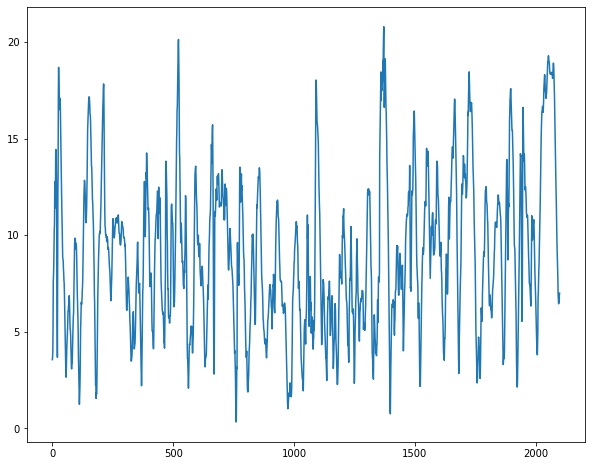

In [185]:
dforc['windSpeed (m/s)'].plot(figsize=(10,8))


In [143]:
import plotly.express as px
fig = px.line(dforc, x=df.index, y='windSpeed (m/s)',  title='wind Speed') #hover_data=[],

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="3m", step="month", stepmode="backward"),
            dict(count=3, label="5m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

ValueError: ignored

#RMSE de los ajustes

In [ ]:
# The mean squared error of interpolate vs linear regression
print('Mean squared error: %.2f'
      % mean_squared_error(df_ws['WSF_int'], ypred_5min))

# The mean squared error of interpolate vs Ridge regression
print('Mean squared error: %.2f'
      % mean_squared_error(df_ws['WSF_int'], y_ridge_pred))

# The mean squared error of linear regression vs Ridge regression
print('Mean squared error: %.2f'
      % mean_squared_error(ypred_5min, y_ridge_pred))

ValueError: ignored

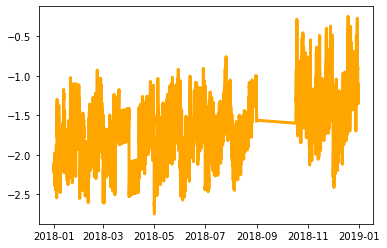

In [ ]:
plt.plot(df_ws['WSF_int']-ypred_5min,  color='orange', linewidth=3)

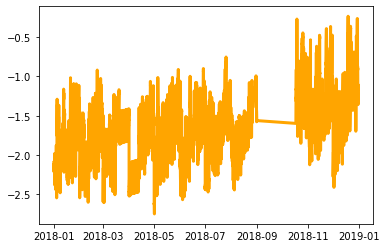

In [ ]:
plt.plot(df_ws['WSF_int']-y_ridge_pred,  color='orange', linewidth=3)

In [ ]:
df[['year','month','day','hour','minute','windSpeed (m/s)','windSpeed']].corr()


timeStamp
2018-01-01 00:00:00     0
2018-01-01 00:05:00     5
2018-01-01 00:10:00    10
2018-01-01 00:15:00    15
2018-01-01 00:20:00    20
                       ..
2018-12-30 23:40:00    40
2018-12-30 23:45:00    45
2018-12-30 23:50:00    50
2018-12-30 23:55:00    55
2018-12-31 00:00:00     0
Name: minute, Length: 88941, dtype: int64

#EDA

In [ ]:
df.head(5)

,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree)
timeStamp,,,,,
2018-12-01 00:00:00,77.4,4.5,3.00625,2.77218,348.166
2018-12-01 00:05:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:10:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:15:00,77.4,5.0,7.48540,NaN,NaN
2018-12-01 00:20:00,77.4,5.0,7.48540,NaN,NaN


In [ ]:
df.shape

(8641, 5)

In [ ]:
df.isnull().sum()

availableMW            3
windSpeed              7
windPower              7
windSpeed (m/s)     7920
windDic (degree)    7920
dtype: int64

#Wind rose

In [ ]:
#rosa de viento
!pip install windrose

In [ ]:
import matplotlib.cm as cm
from math import pi
from windrose import WindroseAxes

In [ ]:
ws_x=df.assign(X=df['windSpeed (m/s)']*np.sin(df["windDic (degree)"]*pi/180.0))
ws_y=df.assign(Y=df['windSpeed (m/s)']*np.cos(df["windDic (degree)"]*pi/180.0))

(<a list of 16 Line2D ticklines objects>,
 <a list of 8 Text major ticklabel objects>)

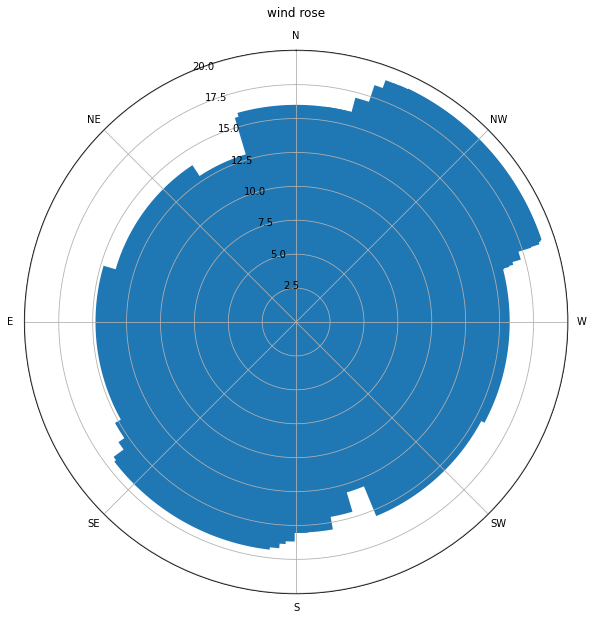

In [ ]:

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N') ## 'origen' de la rotación donde le indiquemos, en este caso el Norte.
ax.set_title('wind rose')  ## Título
ax.bar(df['windDic (degree)']*pi/180.0, df['windSpeed (m/s)']) ## Dibujamos los datos
sectores = ['N','NE','E','SE','S','SW','W','NW']
ax.set_thetagrids(np.arange(0, 360, 45), sectores, fontsize = 10) ## Colocamos las etiquetas del eje x

#Viento

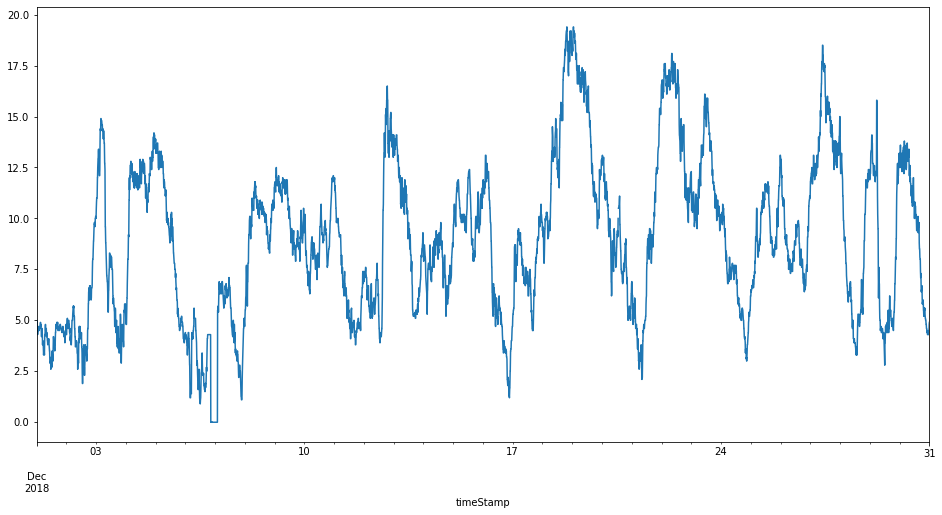

In [ ]:
#df.loc['2018-03-01 00:00:00':'2018-05-01 00:00:00']['windSeed'].plot(figsize=(16,8))
df['windSpeed'].plot(figsize=(16,8))

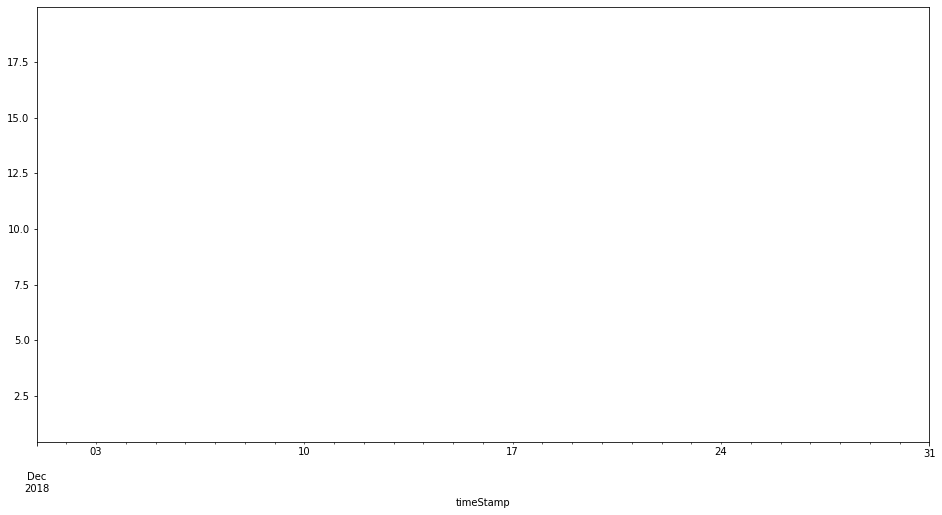

In [ ]:
df['windSpeed (m/s)'].plot(figsize=(16,8))


In [ ]:
#datos medidos data1
df.head()

,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree)
timeStamp,,,,,
2018-12-01 00:00:00,77.4,4.5,3.00625,2.77218,348.166
2018-12-01 00:05:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:10:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:15:00,77.4,5.0,7.48540,NaN,NaN
2018-12-01 00:20:00,77.4,5.0,7.48540,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8641 entries, 2018-12-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   availableMW       8638 non-null   float64
 1   windSpeed         8634 non-null   float64
 2   windPower         8634 non-null   float64
 3   windSpeed (m/s)   721 non-null    float64
 4   windDic (degree)  721 non-null    float64
dtypes: float64(5)
memory usage: 405.0 KB


In [ ]:
df_Data1_ms= pd.read_csv('')

In [ ]:
df_Data1_ms['timeStamp']=pd.to_datetime('timeStamp')
df_Data1_ms.set_index('timeStamp', inplace=True)
df_Data1_ms.info()

ParserError: ignored

In [ ]:
df_Data1_ms.tail()

,availableMW,windSpeed,windPower
timeStamp,,,
2018-12-30 23:40:00,10.5,3.3,0
2018-12-30 23:45:00,5.2,3.1,0
2018-12-30 23:50:00,6,3.1,0
2018-12-30 23:55:00,4.8,3.1,0
2018-12-31 00:00:00,4.5,3.1,0


In [ ]:
df_Data1_ms.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88941 entries, 2018-01-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   availableMW  88941 non-null  object
 1   windSpeed    88941 non-null  object
 2   windPower    88941 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


In [ ]:
df_Data1_ms[df_Data1_ms['windPower']=='0']

,availableMW,windSpeed,windPower
timeStamp,,,
2018-01-16 14:35:00,3,3.1,0
2018-01-16 14:40:00,3,3.1,0
2018-01-16 14:45:00,3,3.1,0
2018-01-16 14:50:00,3,3.1,0
2018-01-16 14:55:00,1.5,3,0
...,...,...,...
2018-12-30 23:40:00,10.5,3.3,0
2018-12-30 23:45:00,5.2,3.1,0
2018-12-30 23:50:00,6,3.1,0


In [ ]:
df_Data1_ms.loc['2018-12-30 23:40:00':'2018-12-31 00:00:00']['windPower']

timeStamp
2018-12-30 23:40:00    0
2018-12-30 23:45:00    0
2018-12-30 23:50:00    0
2018-12-30 23:55:00    0
2018-12-31 00:00:00    0
Name: windPower, dtype: object

In [ ]:
df_Data1_ms['windPower'].unique()

array(['42.5118', '42.7067', '42.3044', '43.3869', '43.2298', '44.0526',
       '44.1584', '44.5217', '43.8115', '43.6778', '44.3364', '44.2532',
       '43.0646', '42.8906', '43.9367', '43.5362', '41.3157', '42.0828',
       '41.5902', '39.5951', '39.172', '41.02', '40.7016', '41.8453',
       '40.3588', '38.7204', '38.2397', '39.9904', '37.7298', '37.1907',
       '36.0261', '36.6227', '33.3744', '32.6516', '31.1459', '31.9081',
       '34.0748', '35.402', '34.7511', '27.1278', '27.9514', '29.5733',
       '25.4668', '28.7674', '23.8034', '22.9766', '30.3669', '26.2988',
       '18.975', '17.4705', '21.3434', '20.5412', '19.7512', '18.2143',
       '15.3518', '10.6199', '8.72254', '11.1388', '14.0416', '11.6776',
       '14.6861', '12.2368', '12.817', '13.4185', '16.7448', '24.6343',
       '22.1558', '16.0383', '10.1198', '9.17233', '7.05438', '6.66415',
       '6.28263', '5.54314', '8.2871', '7.86474', '5.90912', '4.83331',
       '3.21457', '2.65507', '2.92703', '1.94218', '1.1744

In [ ]:
df_Data1_ms['windPower']=df_Data1_ms['windPower'].astype(float)

ValueError: ignored

In [ ]:
df_Data1_ms[df_Data1_ms['windPower']=='\\N']['windPower'].count()

856

In [ ]:
s=df_Data1_ms['windPower']
pd.to_numeric(s, downcast='float')

In [ ]:
df_Data1_ms[df_Data1_ms['windPower']=='0']['windPower'].plot()

In [ ]:
##Comienza aqui data1 medidas 

In [ ]:
df_Data1_ms=pd.read_csv('/content/Dataset1_measurement.csv', index_col='timeStamp', parse_dates=True)

In [ ]:
df_Data1_ms.head()

,availableMW,windSpeed,windPower
timeStamp,,,
2018-01-01 00:00:00,34.5,11.9,42.5118
2018-01-01 00:05:00,34.5,12,42.7067
2018-01-01 00:10:00,34.5,12,42.7067
2018-01-01 00:15:00,34.5,11.8,42.3044
2018-01-01 00:20:00,34.5,11.8,42.3044


In [ ]:
df_Data1_ms[df_Data1_ms['windPower']=='\\N']=0



In [ ]:
df_Data1_ms['availableMW'][df_Data1_ms['availableMW']=='\\N']=0

In [ ]:
df_Data1_ms[df_Data1_ms['windSpeed']=='\\N']

,availableMW,windSpeed,windPower
timeStamp,,,


In [ ]:
df_Data1_ms=df_Data1_ms.astype(float)

In [ ]:
df_Data1_ms.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88941 entries, 2018-01-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   availableMW  88941 non-null  float64
 1   windSpeed    88941 non-null  float64
 2   windPower    88941 non-null  float64
dtypes: float64(3)
memory usage: 2.7 MB


In [ ]:
df_Data1_ms[df_Data1_ms['windSpeed']<=3.5]= np.NaN

In [ ]:
df_Data1_ms.isnull().sum()

availableMW    8680
windSpeed      8680
windPower      8680
dtype: int64

In [ ]:
df_Data1_ms_sinI= df_Data1_ms.reset_index()

In [ ]:
df_Data1_ms_sinI[df_Data1_ms_sinI['availableMW'].isnull()==True].describe()

,availableMW,windSpeed,windPower
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [ ]:
df_Data1_ms_sinI.dropna(inplace=True)

In [ ]:
df_Data1_ms_sinI['timeStamp']=pd.to_datetime(df_Data1_ms_sinI['timeStamp'])


In [ ]:
df_Data1_ms_sinI['timeStamp']

0       2018-01-01 00:00:00
1       2018-01-01 00:05:00
2       2018-01-01 00:10:00
3       2018-01-01 00:15:00
4       2018-01-01 00:20:00
                ...        
88878   2018-12-30 18:50:00
88931   2018-12-30 23:15:00
88932   2018-12-30 23:20:00
88933   2018-12-30 23:25:00
88934   2018-12-30 23:30:00
Name: timeStamp, Length: 80261, dtype: datetime64[ns]

In [ ]:
df_Data1_ms_sinI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80261 entries, 0 to 88934
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timeStamp    80261 non-null  datetime64[ns]
 1   availableMW  80261 non-null  float64       
 2   windSpeed    80261 non-null  float64       
 3   windPower    80261 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.1 MB


In [ ]:
df_Data1_ms_sinI.set_index('timeStamp', inplace=True)


In [ ]:
df_Data1_ms_sinI.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2018-12-30 18:25:00', '2018-12-30 18:30:00',
               '2018-12-30 18:35:00', '2018-12-30 18:40:00',
               '2018-12-30 18:45:00', '2018-12-30 18:50:00',
               '2018-12-30 23:15:00', '2018-12-30 23:20:00',
               '2018-12-30 23:25:00', '2018-12-30 23:30:00'],
              dtype='datetime64[ns]', name='timeStamp', length=80261, freq=None)

In [ ]:
df_Data1_ms_mean_horario= df_Data1_ms_sinI.resample('h').mean()

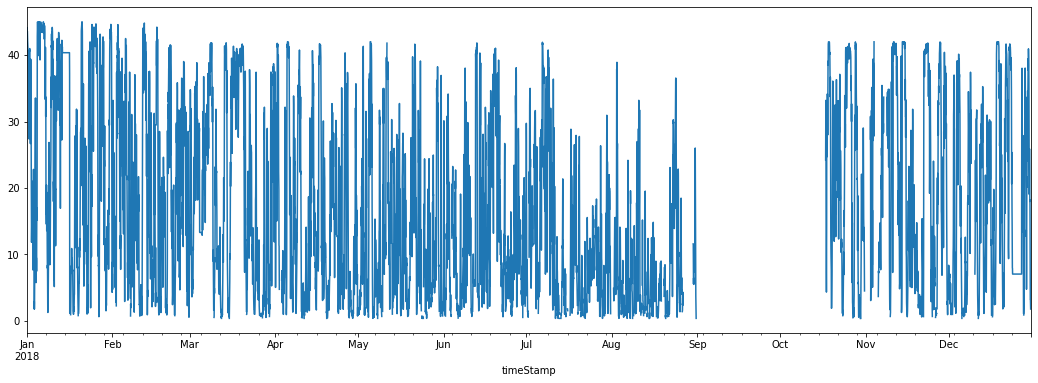

In [ ]:
df_Data1_ms_mean_horario['windPower'].plot(figsize=(18,6))

In [ ]:
df_Data1_ms_mean_horario.describe()

,availableMW,windSpeed,windPower
count,6965.000000,6965.000000,6965.000000
mean,37.370194,7.664126,17.600980
std,6.470893,2.613197,13.545999
min,0.000000,3.600000,0.376286
25%,36.025000,5.600000,5.682594
50%,39.133333,7.316667,13.775765
75%,41.350000,9.416667,29.281650
max,42.000000,16.875000,45.000000


In [ ]:
df_Data1_ms_mean_horario[df_Data1_ms_mean_horario['availableMW']==0]

,availableMW,windSpeed,windPower
timeStamp,,,
2018-01-16 21:00:00,0.0,3.800000,0.929913
2018-01-19 17:00:00,0.0,3.600000,0.440938
2018-02-07 14:00:00,0.0,3.700000,0.735884
2018-03-09 21:00:00,0.0,3.722222,0.662555
2018-03-15 09:00:00,0.0,3.600000,0.376286
2018-04-05 02:00:00,0.0,4.266667,1.759847
2018-11-07 12:00:00,0.0,10.320000,33.668520
2018-11-09 21:00:00,0.0,3.700000,0.663650
2018-11-13 23:00:00,0.0,4.000000,1.259820


In [ ]:
df_Data1_ms_mean_horario_re['timeStamp'].value_counts().describe()

count    8736.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: timeStamp, dtype: float64

In [ ]:
df_Data1_ms_mean_horario_re=df_Data1_ms_mean_horario.reset_index()


Text(0, 0.5, 'potencia')

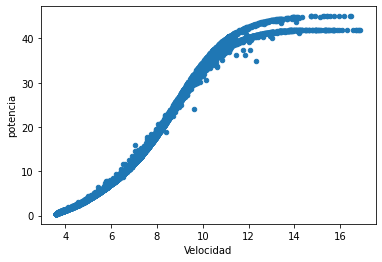

In [ ]:

df_Data1_ms_mean_horario_re.plot(kind='scatter',x='windSpeed',y='windPower')
plt.xlabel('Velocidad')
plt.ylabel('potencia')

Text(0, 0.5, 'potencia')

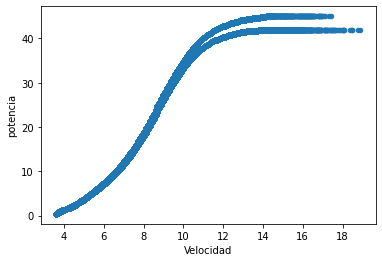

In [ ]:
df_Data1_ms_sinI.plot(kind='scatter',x='windSpeed',y='windPower')
plt.xlabel('Velocidad')
plt.ylabel('potencia')

In [ ]:
df_Data1_ms_mean_horario_re.head()

,timeStamp,availableMW,windSpeed,windPower
0,2018-01-01 00:00:00,34.5,12.200000,43.023300
1,2018-01-01 01:00:00,34.5,13.033333,44.152292
2,2018-01-01 02:00:00,34.5,12.225000,43.070175
3,2018-01-01 03:00:00,34.5,12.175000,43.008333
4,2018-01-01 04:00:00,34.5,12.558333,43.604258


In [ ]:
%matplotlib inline

In [ ]:
df

,availableMW,windSpeed,windPower,windSpeed (m/s),windDic (degree)
timeStamp,,,,,
2018-12-01 00:00:00,77.4,4.5,3.00625,2.772180,348.166000
2018-12-01 00:05:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:10:00,77.4,4.8,5.65763,NaN,NaN
2018-12-01 00:15:00,77.4,5.0,7.48540,NaN,NaN
2018-12-01 00:20:00,77.4,5.0,7.48540,NaN,NaN
...,...,...,...,...,...
2018-12-30 23:40:00,97.2,4.4,2.19283,NaN,NaN
2018-12-30 23:45:00,97.2,4.8,5.65763,NaN,NaN
2018-12-30 23:50:00,97.2,4.8,5.65763,NaN,NaN


No handles with labels found to put in legend.


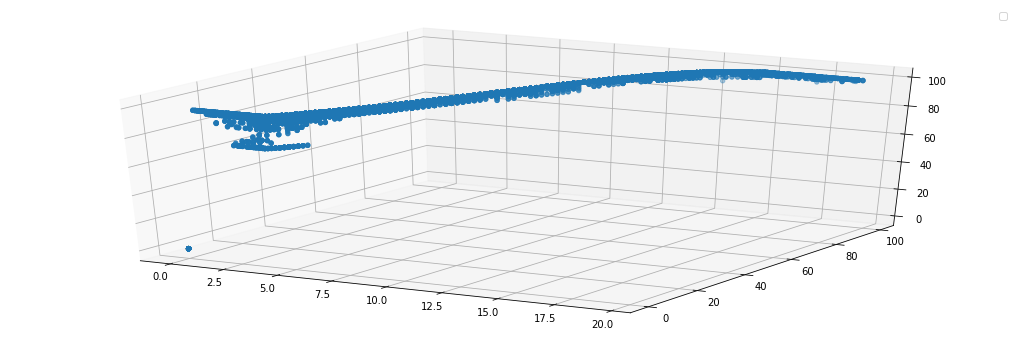

In [ ]:

fig=plt.figure(figsize=(18,6))
ax= fig.gca(projection= '3d')
ax.scatter3D(df['windSpeed'],df['windPower'],df['availableMW'])
plt.legend()
plt.show()

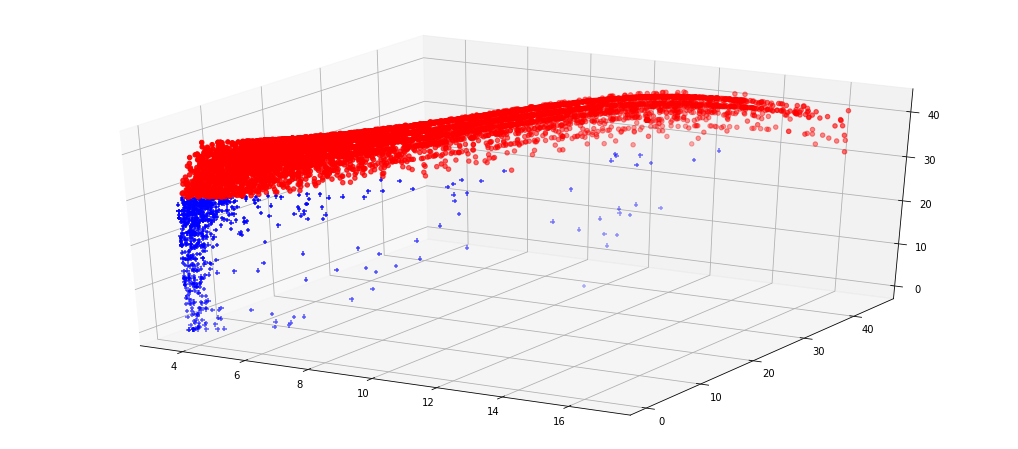

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Creamos la figura
fig = plt.figure(figsize=(18,8))
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = df['windSpeed']
y = df['windPower']
z = df['availableMW']

# Datos con disponibilidad <=30
x2 = df['windSpeed'][df['availableMW']<=30]
y2 = df['windPower'][df['availableMW']<=30]
z2 = df['availableMW'][df['availableMW']<=30]

# Datos con disponibilidad >30
x3 = df['windSpeed'][df['availableMW']>30]
y3 = df['windPower'][df['availableMW']>30]
z3 = df['availableMW'][df['availableMW']>30]
# Agregamos los puntos en el plano 3D
#ax1.scatter(x, y, z, c='g', marker='o')
ax1.scatter(x2, y2, z2, c ='b', marker='+')
ax1.scatter(x3, y3, z3, c ='r', marker='o')

# Mostramos el gráfico
plt.show()


In [ ]:
df_HGT30= df_Data1_ms_mean_horario_re[df_Data1_ms_mean_horario_re['availableMW']>30]

In [ ]:
df_HGT30['available_cat']=df_HGT30['availableMW'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_HGT30[df_HGT30['available_cat']==42].describe()

,availableMW,windSpeed,windPower,available_cat
count,1379.0,1379.000000,1379.000000,1379.0
mean,42.0,8.827048,23.582521,42.0
std,0.0,2.070198,11.652977,0.0
min,42.0,4.233333,1.706471,42.0
25%,42.0,7.300000,13.296500,42.0
50%,42.0,8.700000,23.573058,42.0
75%,42.0,10.212500,34.160004,42.0
max,42.0,15.550000,44.209667,42.0


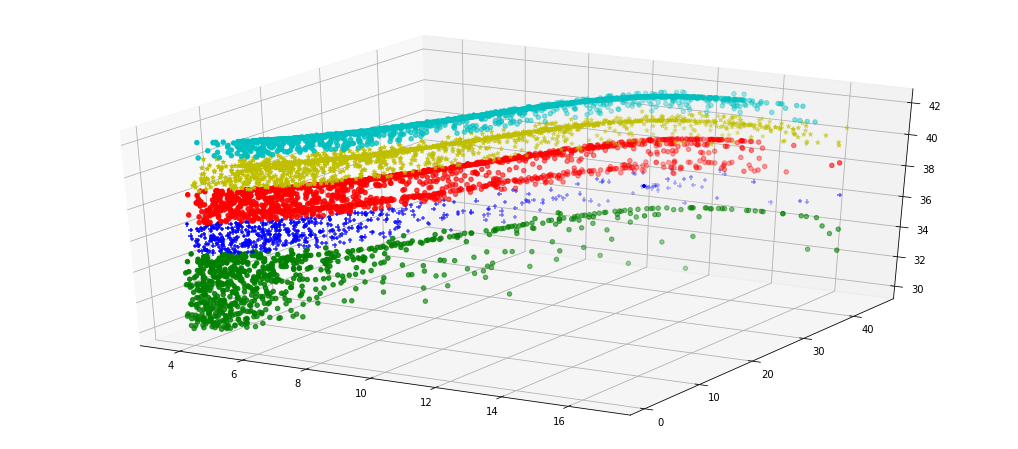

In [ ]:
# Creamos la figura
fig = plt.figure(figsize=(18,8))
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = df_HGT30['windSpeed'][(df_HGT30['available_cat']>30) &(df_HGT30['available_cat']<=35)]
y = df_HGT30['windPower'][(df_HGT30['available_cat']>30) &(df_HGT30['available_cat']<=35)]
z = df_HGT30['availableMW'][(df_HGT30['available_cat']>30) &(df_HGT30['available_cat']<=35)]

# Datos con disponibilidad <=25
x2 = df_HGT30['windSpeed'][(df_HGT30['available_cat']>36) ]
y2 = df_HGT30['windPower'][(df_HGT30['available_cat']>35) ]
z2 = df_HGT30['availableMW'][(df_HGT30['available_cat']>35) ]


# Datos con disponibilidad <=25
x3 = df_HGT30['windSpeed'][(df_HGT30['available_cat']>37) ]
y3 = df_HGT30['windPower'][(df_HGT30['available_cat']>37) ]
z3 = df_HGT30['availableMW'][(df_HGT30['available_cat']>37) ]

# Datos con disponibilidad <=25
x4 = df_HGT30['windSpeed'][(df_HGT30['available_cat']>39) ]
y4 = df_HGT30['windPower'][(df_HGT30['available_cat']>39) ]
z4 = df_HGT30['availableMW'][(df_HGT30['available_cat']>39) ]
# Datos con disponibilidad >25
x5 = df_HGT30['windSpeed'][df_HGT30['available_cat']>41]
y5 = df_HGT30['windPower'][df_HGT30['available_cat']>41]
z5 = df_HGT30['availableMW'][df_HGT30['available_cat']>41]

# Agregamos los puntos en el plano 3D
ax1.scatter(x, y, z, c='g', marker='o')
ax1.scatter(x2, y2, z2, c ='b', marker='+')
ax1.scatter(x3, y3, z3, c ='r', marker='o')
ax1.scatter(x4, y4, z4, c ='y', marker='*')
ax1.scatter(x5, y5, z5, c ='c', marker='o')

# Mostramos el gráfico
plt.show()


In [ ]:
df_HGT30.describe()

,availableMW,windSpeed,windPower
count,6323.000000,6323.000000,6323.000000
mean,39.045618,7.984341,19.032782
std,2.898832,2.486048,13.216014
min,30.016667,3.700000,0.663650
25%,37.500000,6.000000,7.044440
50%,40.000000,7.633333,15.786267
75%,41.708333,9.616667,30.469667
max,42.000000,16.875000,45.000000


Text(0, 0.5, 'potencia')

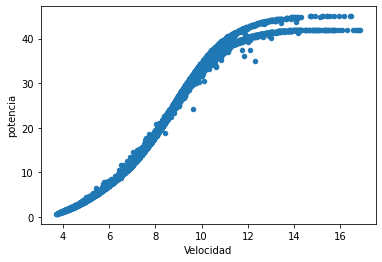

In [ ]:
df_HGT30.plot(kind='scatter',x='windSpeed',y='windPower')
plt.xlabel('Velocidad')
plt.ylabel('potencia')

In [ ]:
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


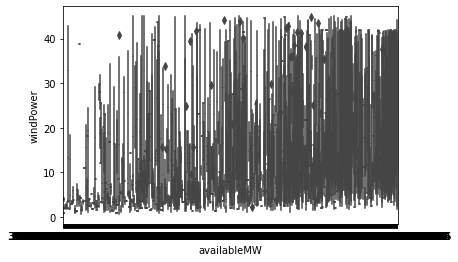

In [ ]:
sn.boxplot(df_HGT30['availableMW'], df_HGT30['windPower'])

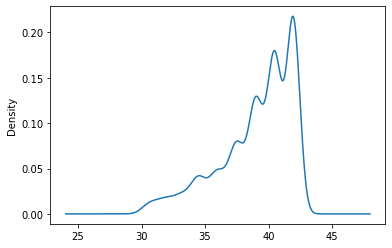

In [ ]:
df_HGT30['availableMW'].plot(kind='density')

In [ ]:
df_HGT30['availableMW']<35


0        True
1        True
2        True
3        True
4        True
        ...  
8726    False
8727    False
8728    False
8729    False
8730    False
Name: availableMW, Length: 6323, dtype: bool

In [ ]:
df_HGT30['availableK']=df_HGT30[(df_HGT30['availableMW']<35)==True]=30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [ ]:
df_HGT30['availableK']

0       30
1       30
2       30
3       30
4       30
        ..
8726    30
8727    30
8728    30
8729    30
8730    30
Name: availableK, Length: 6323, dtype: int64

In [ ]:
df_HGT30.loc['available_cat']=df_HGT30['availableMW'][df_HGT30['availableMW']<35]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_HGT30.loc['available_cat']=df_HGT30['availableMW'][(df_HGT30['availableMW']>=35) & (df_HGT30['availableMW']<40 )]=35

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
df_HGT30

,timeStamp,availableMW,windSpeed,windPower,available_cat
0,30,30.0,30.000000,30.000000,30.0
1,30,30.0,30.000000,30.000000,30.0
2,30,30.0,30.000000,30.000000,30.0
3,30,30.0,30.000000,30.000000,30.0
4,30,30.0,30.000000,30.000000,30.0
...,...,...,...,...,...
8727,2018-12-30 15:00:00,35.0,4.900000,3.298734,NaN
8728,2018-12-30 16:00:00,35.0,4.900000,3.305925,NaN
8729,2018-12-30 17:00:00,35.0,4.583333,2.485664,NaN
8730,2018-12-30 18:00:00,35.0,4.272727,1.777235,NaN


In [ ]:
df_HGT30[df_HGT30['availableMW']>35]

,timeStamp,availableMW,windSpeed,windPower,available_cat,availableK
36,2018-01-02 12:00:00,35.050000,10.325000,36.641125,NaN,30.0
37,2018-01-02 13:00:00,35.908333,9.641667,32.104900,NaN,30.0
38,2018-01-02 14:00:00,37.300000,9.191667,28.679625,NaN,30.0
39,2018-01-02 15:00:00,38.341667,8.208333,20.651800,NaN,30.0
40,2018-01-02 16:00:00,37.775000,7.200000,13.775765,NaN,30.0
...,...,...,...,...,...,...
8726,2018-12-30 14:00:00,37.641667,5.466667,5.170752,NaN,30.0
8727,2018-12-30 15:00:00,37.500000,4.900000,3.298734,NaN,30.0
8728,2018-12-30 16:00:00,37.500000,4.900000,3.305925,NaN,30.0
8729,2018-12-30 17:00:00,37.441667,4.583333,2.485664,NaN,30.0


In [ ]:
df_HGT30[df_HGT30['availableMW']>35].describe()

,availableMW,windSpeed,windPower,available_cat,availableK
count,5557.000000,5557.000000,5557.000000,0.0,5557.0
mean,39.865099,8.229038,20.230308,NaN,30.0
std,1.935658,2.390543,12.905182,NaN,0.0
min,35.008333,3.866667,1.014012,NaN,30.0
25%,38.791667,6.325000,8.525994,NaN,30.0
50%,40.500000,7.925000,17.729217,NaN,30.0
75%,41.975000,9.758333,31.381950,NaN,30.0
max,42.000000,16.833333,45.000000,NaN,30.0


In [ ]:
df_HGT30.drop('availableK', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_HGT30

,timeStamp,availableMW,windSpeed,windPower,available_cat
0,30,30.000000,30.000000,30.000000,30.0
1,30,30.000000,30.000000,30.000000,30.0
2,30,30.000000,30.000000,30.000000,30.0
3,30,30.000000,30.000000,30.000000,30.0
4,30,30.000000,30.000000,30.000000,30.0
...,...,...,...,...,...
8727,2018-12-30 15:00:00,37.500000,4.900000,3.298734,NaN
8728,2018-12-30 16:00:00,37.500000,4.900000,3.305925,NaN
8729,2018-12-30 17:00:00,37.441667,4.583333,2.485664,NaN
8730,2018-12-30 18:00:00,37.009091,4.272727,1.777235,NaN
